In [17]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np 
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing , SimpleExpSmoothing , Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv('gold_monthly_csv.csv')

In [20]:
date = pd.date_range(start='1/1/1950',end='8/1/2020',freq='ME')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='ME')

In [21]:
df['month'] = date
df.drop('Date',axis=1,inplace=True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


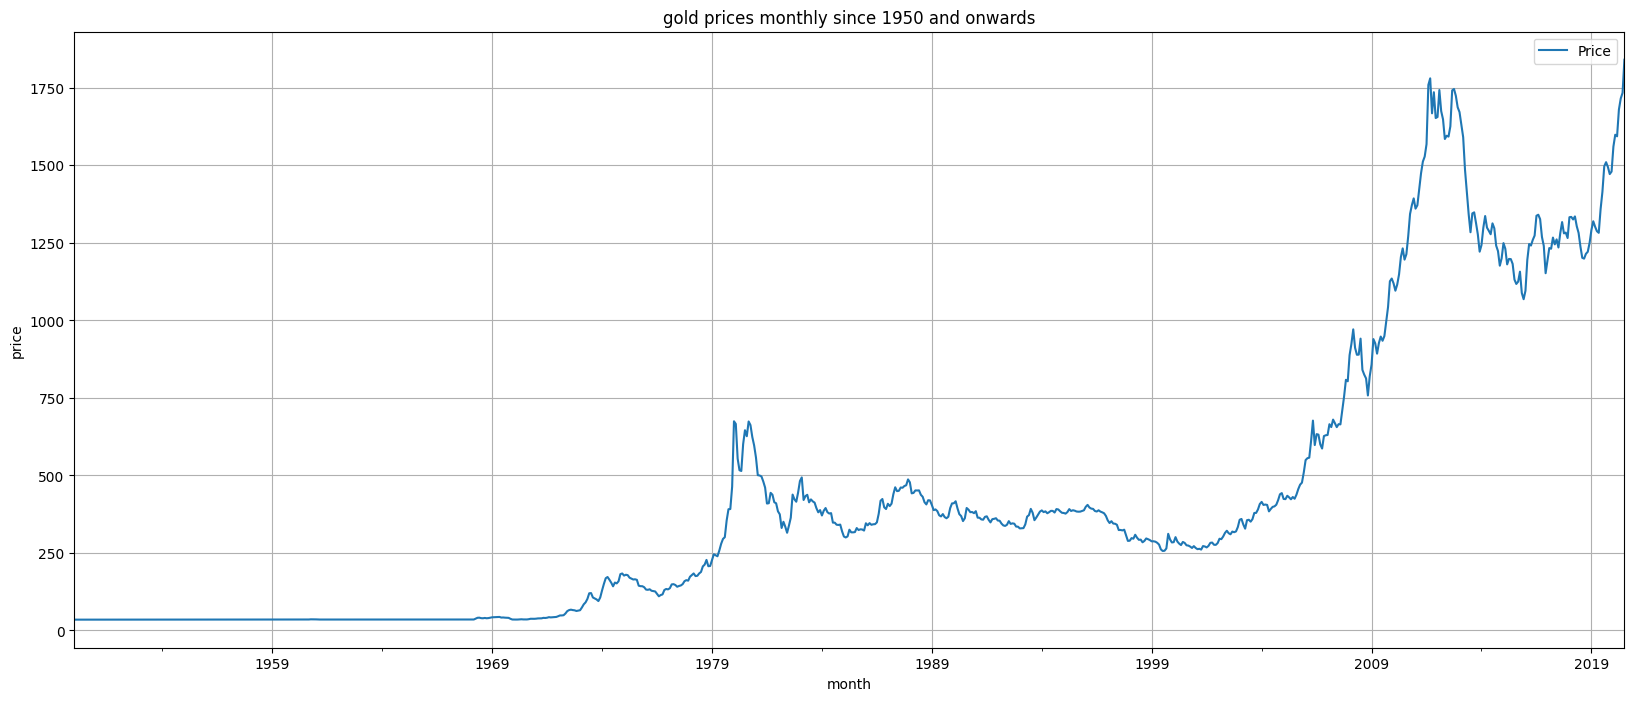

In [22]:
df.plot(figsize=(20,8))
plt.title("gold prices monthly since 1950 and onwards")
plt.xlabel("month")
plt.ylabel('price')
plt.grid()

<module 'matplotlib.pyplot' from '/var/data/python/lib/python3.12/site-packages/matplotlib/pyplot.py'>

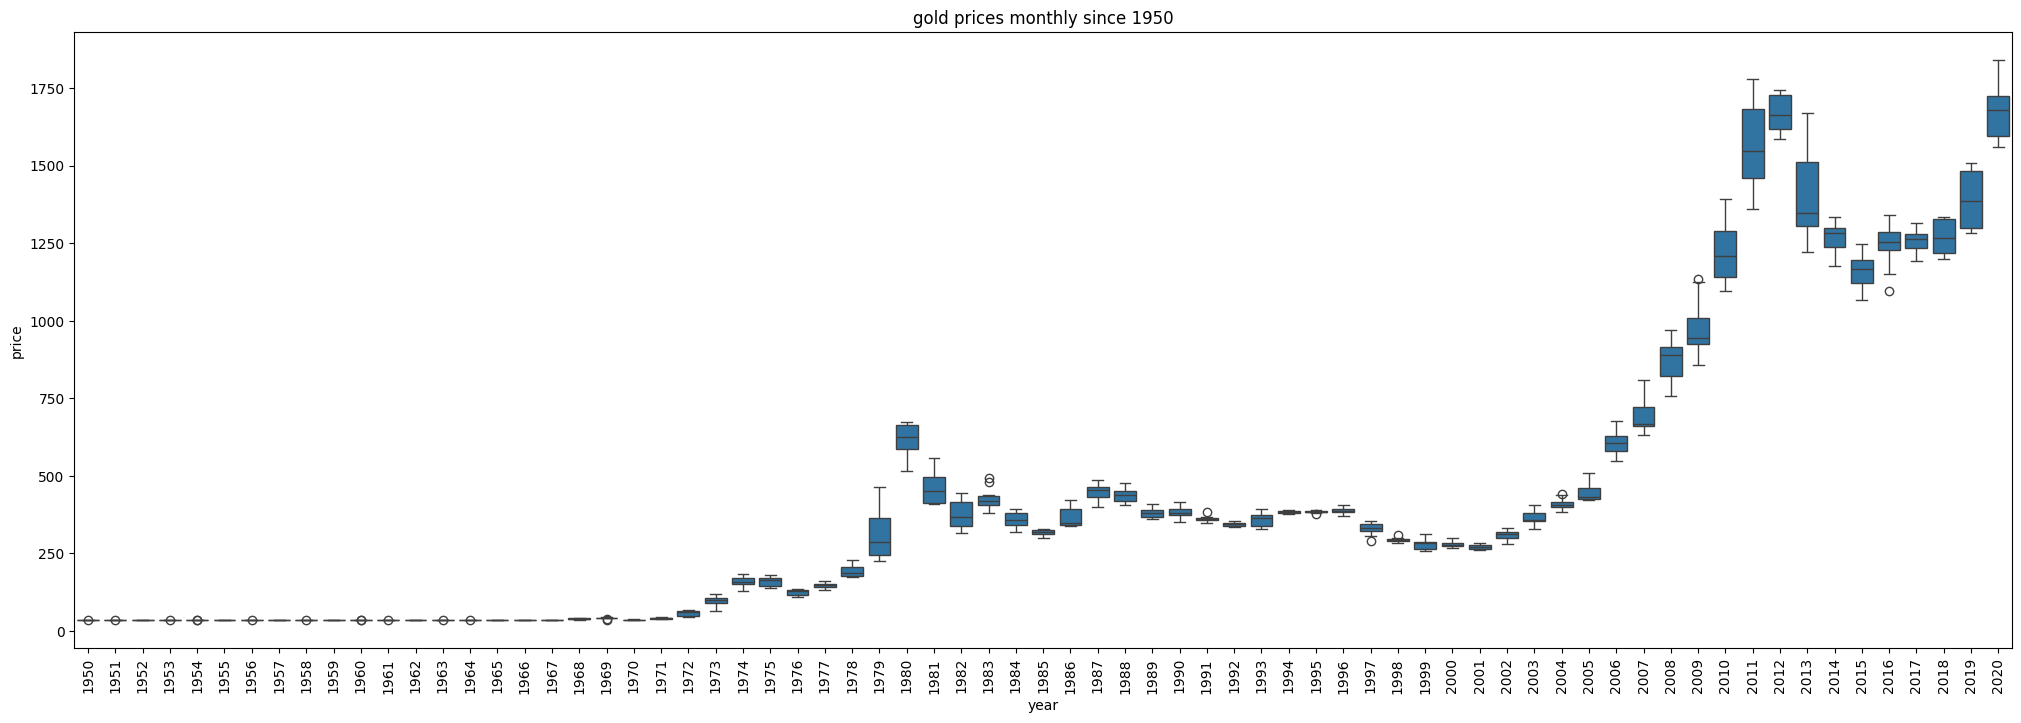

In [23]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.year , y = df.values[:,0],ax=ax)
plt.title("gold prices monthly since 1950")
plt.xlabel('year')
plt.ylabel('price')
plt.xticks(rotation=90)
plt

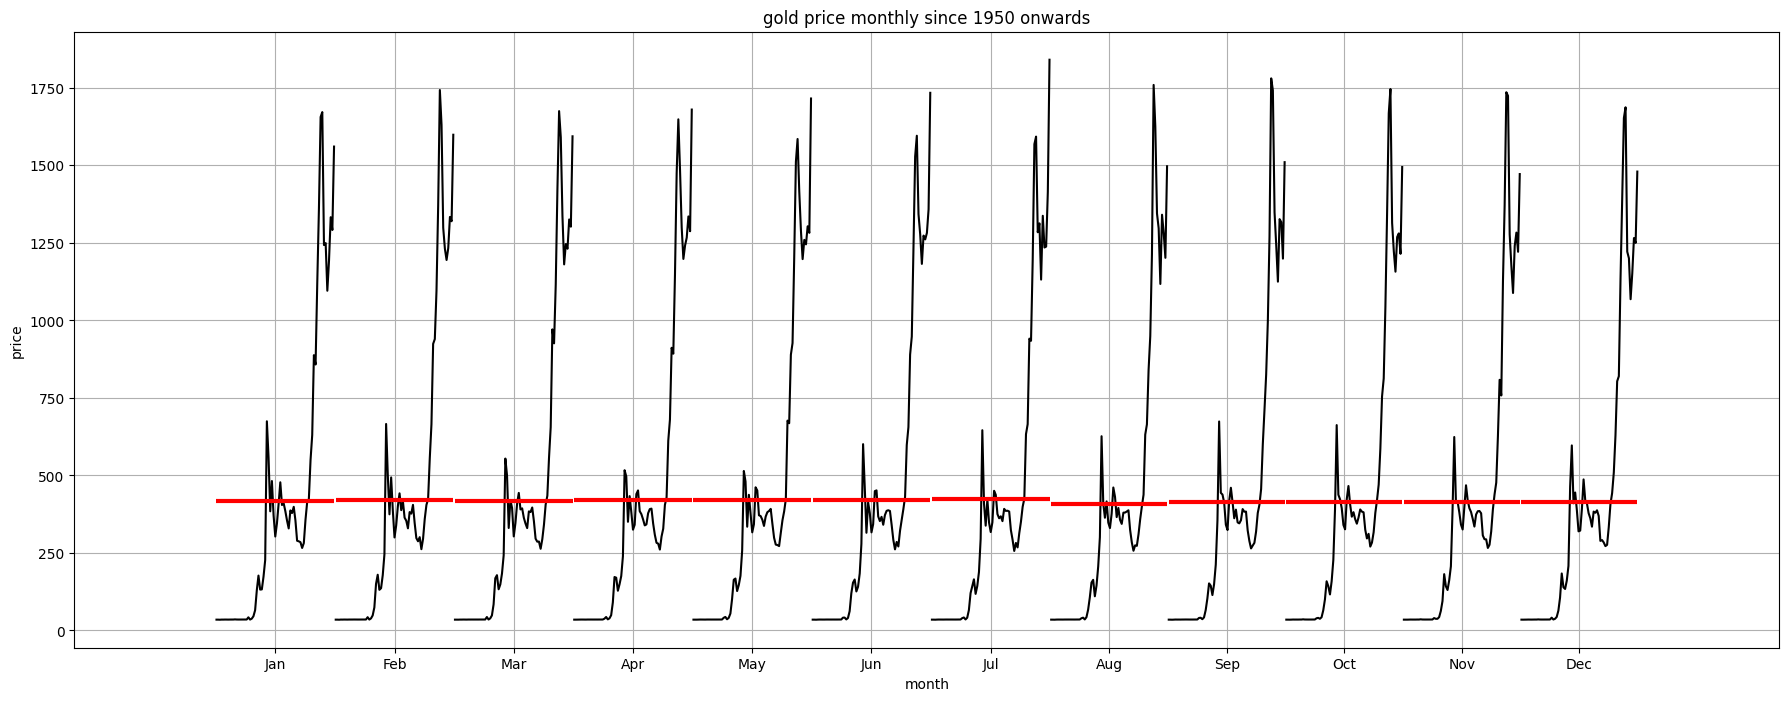

In [24]:
from statsmodels.graphics.tsaplots import month_plot

fig,ax = plt.subplots(figsize=(22,8))
month_plot(df,ylabel = 'gold price',ax=ax)

plt.title('gold price monthly since 1950 onwards')
plt.xlabel('month')
plt.ylabel('price')

plt.grid()


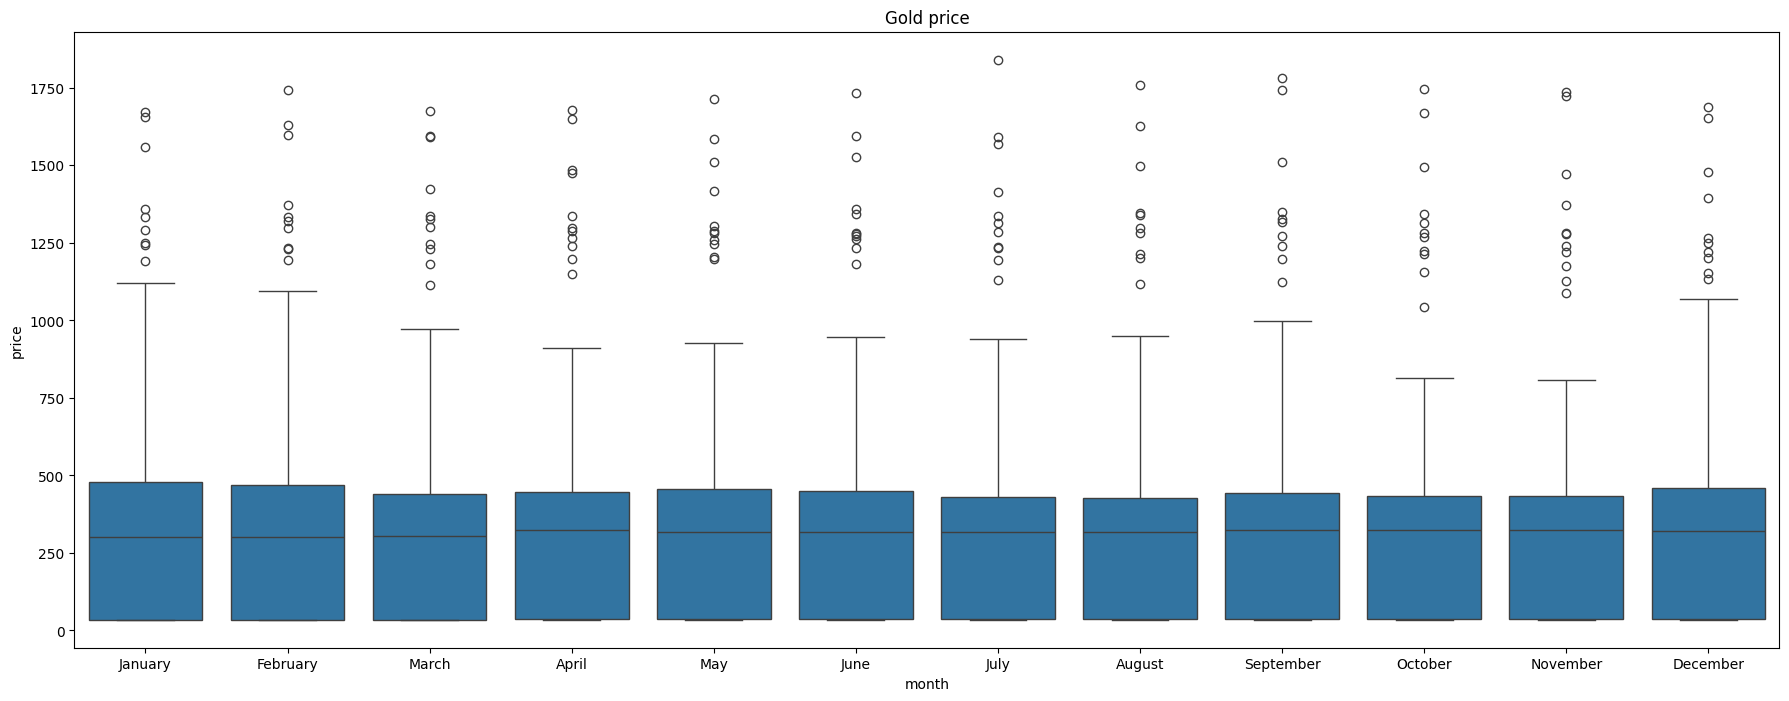

In [25]:
_,ax = plt.subplots(figsize = (22,8))
sns.boxplot(x=df.index.month_name(),y=df.values[:,0],ax=ax)

plt.title("Gold price")
plt.xlabel('month')
plt.ylabel('price')
plt.show()

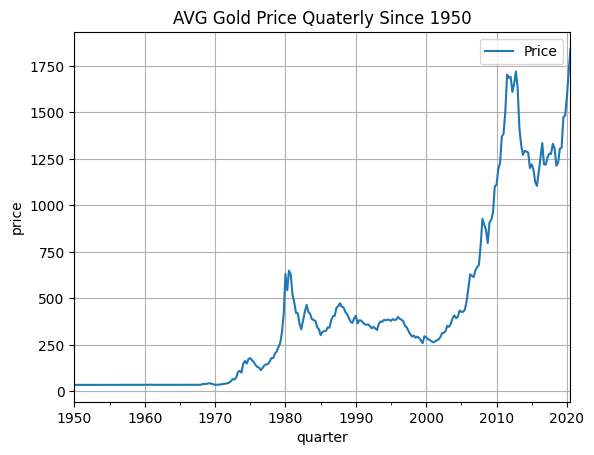

In [26]:
df.quaterly_sum = df.resample('Q').mean()
df.quaterly_sum.plot()
plt.title("AVG Gold Price Quaterly Since 1950")
plt.xlabel('quarter')
plt.ylabel('price')
plt.grid()

Text(0.5, 1.0, 'avg gold prices per 10Y')

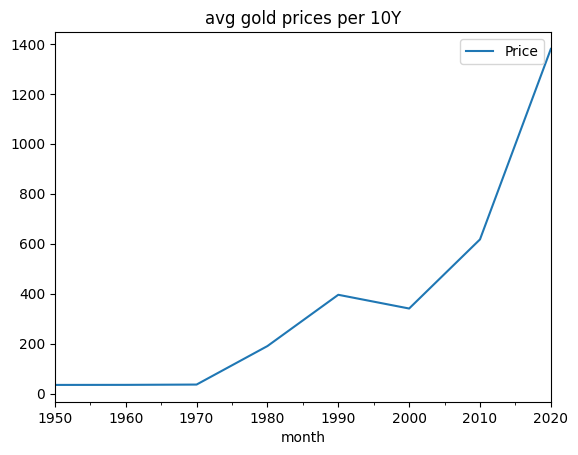

In [27]:
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot()
plt.title('avg gold prices per 10Y')

In [29]:
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}),left_index=True,right_index=True)
df_1['Cov_pct'] = ((df_1['Std']/df_1['Mean'])).round(2)
df_1.head()

,Mean,Std,Cov_pct
month,,,
1950,34.729167,0.002887,0.0
1951,34.717500,0.020057,0.0
1952,34.628333,0.117538,0.0
1953,34.879167,0.056481,0.0
1954,35.020000,0.082792,0.0


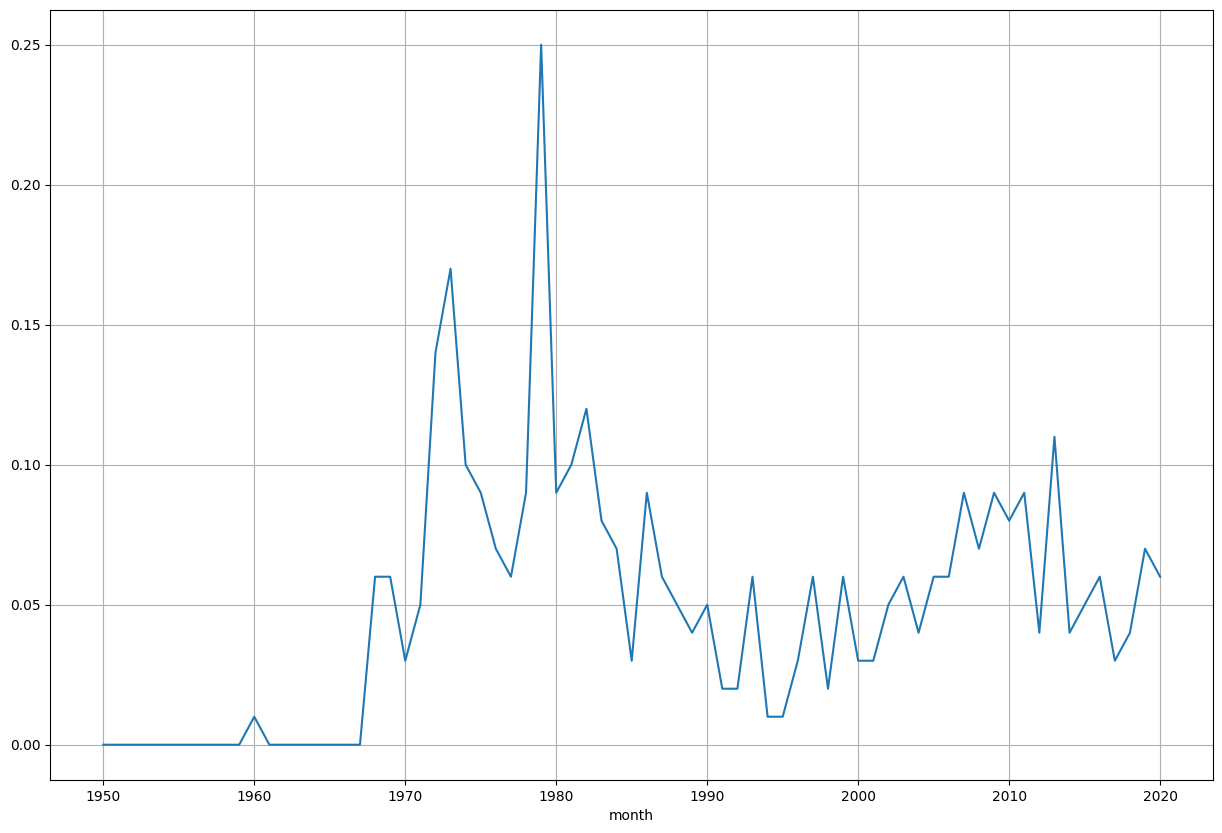

In [31]:
fig , ax = plt.subplots(figsize=(15,10))
df_1['Cov_pct'].plot()
plt.grid()

In [32]:
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]

In [33]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


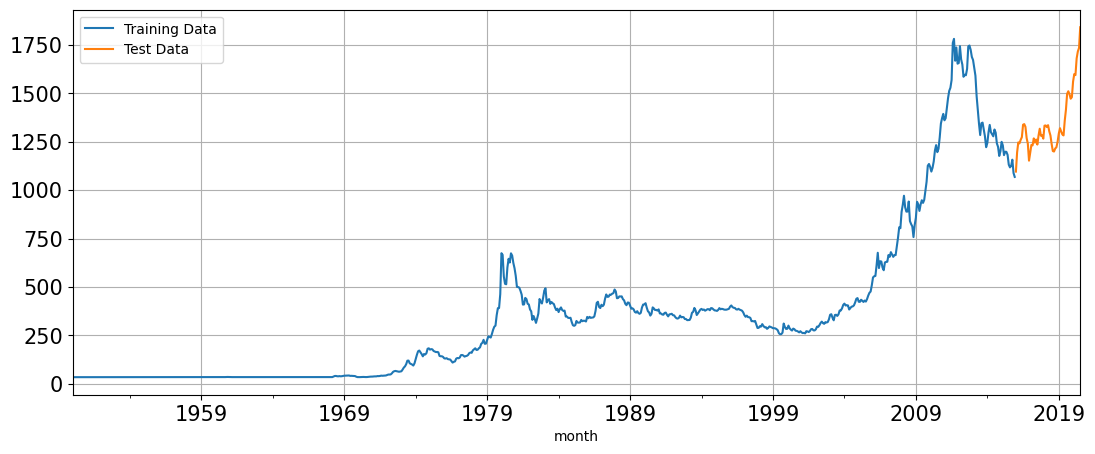

In [34]:
train['Price'].plot(figsize=(13,5),fontsize=15)
test['Price'].plot(figsize=(13,5),fontsize=15)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()


In [36]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]

In [37]:
LR_train = train.copy()
LR_test = test.copy()

In [38]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [40]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train['Price'].values)

LinearRegression()

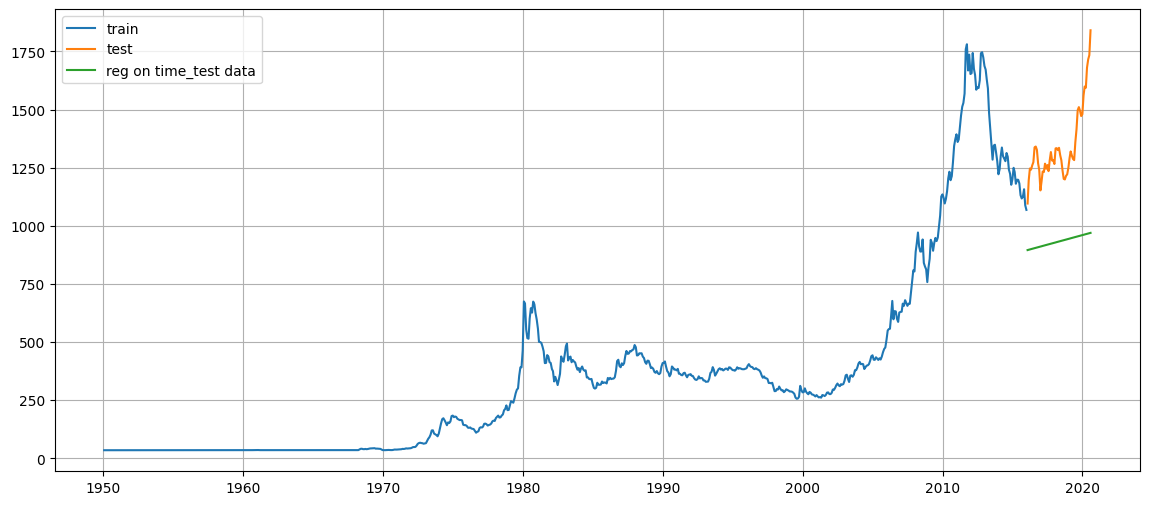

In [45]:
test_prediction_model = lr.predict(LR_test[['time']])

LR_test['forecast'] = test_prediction_model

plt.figure(figsize=(14,6))
plt.plot(train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(LR_test['forecast'],label='reg on time_test data')
plt.legend(loc='best')
plt.grid()
                              

In [46]:
def mape(actual,predicted):
    return round((np.mean(abs(actual-predicted)/actual))*100,2)

In [49]:
mape_model_test = mape(test['Price'].values,test_prediction_model)

In [51]:
print('MAPE is %3.3f'%(mape_model_test),"%")

MAPE is 29.760 %


In [53]:
results = pd.DataFrame({'Test Mape (%)':[mape_model_test]},index=['RegressionOnTime'])
results

,Test Mape (%)
RegressionOnTime,29.76


In [54]:
naive_train = train.copy()
naive_test = train.copy()

In [64]:
naive_test['naive'] = np.asarray(train ['Price'])[len(np.asarray(train['Price']))-1]
naive_test['naive'].head()

month
1950-01-31    1068.317
1950-02-28    1068.317
1950-03-31    1068.317
1950-04-30    1068.317
1950-05-31    1068.317
Name: naive, dtype: float64

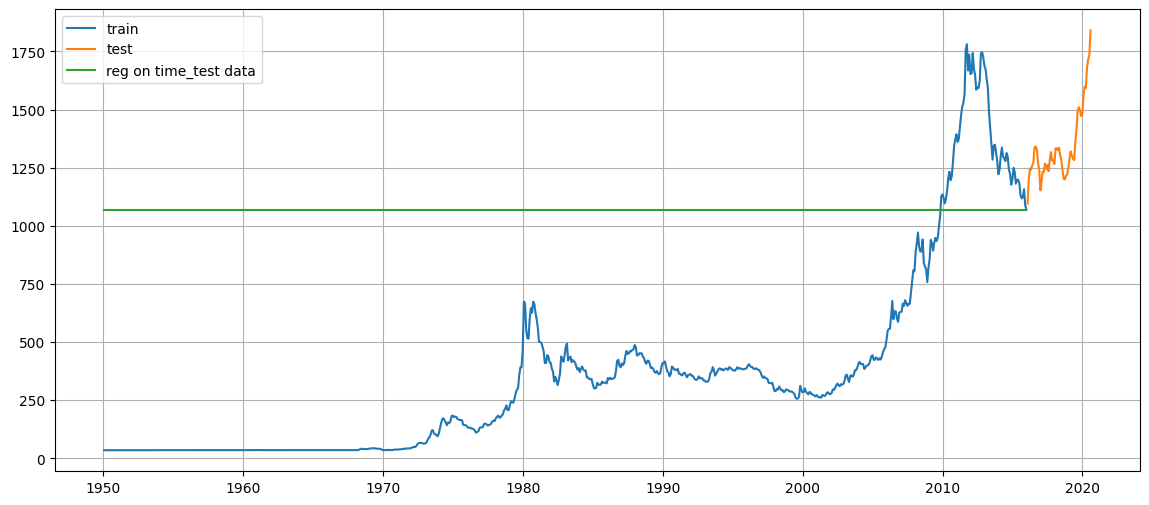

In [65]:
plt.figure(figsize=(14,6))
plt.plot(naive_train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(naive_test['naive'],label='reg on time_test data')
plt.legend(loc='best')
plt.grid()
           

In [66]:
mape_model2_test = mape(test['Price'].values,naive_test['naive'].values)

ValueError: operands could not be broadcast together with shapes (55,) (792,) 

In [ ]:
results2 = pd.DataFrame({'Test Mape (%)':[mape_model_test]},index=['RegressionOnTime'])
results = pd.concat([results,results2])
results

In [67]:
final_model = ExponentialSmoothing(df,trend='additive',seasonal='additive').fit(smoothing_level = 0.4,smoothing_trend=0.3,smoothing_seasonal=0.6)

In [ ]:
Mape_final_model = mape(df['Price'].values,final_model.fittedvalues)
print('MAPE',Mape_final_model)

In [68]:
predictions = final_model.forecast(steps=len(test))

In [ ]:
pred_df = pd.DataFrame({'lower_CI':prediction - 1.96*np.std(final_model.resid,ddof=1),
                        'predicton':prediction,
                        'upper_CI':prediction + 1.96 * np.std(final_model.resid,ddof=1)
                        })
pred_df.head()

In [ ]:
axis = df.plot(label='Actual', figsize=(15,9))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color='m', alpha=0.15)
axis.set_xlabel('year-month')
axis.set_ylabel('price')
plt.legend(loc='best')
plt.grid()
plt.show()
